In [1]:
#Import numpy, syotools, and astropy.units
### NOTE: you will likely receive some pysynphot warnings when executing these imports, these are expected
import numpy as np
from glob import glob
from pprint import pprint
from syotools import cdbs #make sure that pysynphot can find its reference files!
from syotools.models import Telescope, Camera, Spectrograph #models for the observatory and instruments
from syotools.utils.jsonunit import str_jsunit #for printing JsonUnit and JsonSpectrum wrappers in a readable way
from syotools.utils import pre_encode, pre_decode
from syotools.spectra import SpectralLibrary
from astropy.nddata import NDData
import astropy.units as u
from speclite.filters import FilterResponse, load_filters, plot_filters

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/hwo/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
hwo_ex1 = Telescope()
hwo_ex1.set_from_json('EAC1') 

hri = Camera()
hwo_ex1.add_camera(hri)

Setting Telescope to:  EAC1


In [3]:
pivotwave, bandpass = hri.recover('pivotwave', 'derived_bandpass')

for band, pwave, bpass in zip(hri.bandnames, pivotwave, bandpass):
    print(u"   {:3s} - {:5.2f} ± {:5.2f}".format(band, pwave, bpass)) 

   FUV - 225.00 nm ± 45.00 nm
   NUV - 275.00 nm ± 55.00 nm
   U   - 336.00 nm ± 67.20 nm
   B   - 475.00 nm ± 95.00 nm
   V   - 606.00 nm ± 121.20 nm
   R   - 775.00 nm ± 155.00 nm
   I   - 850.00 nm ± 170.00 nm
   J   - 1260.00 nm ± 252.00 nm
   H   - 1600.00 nm ± 320.00 nm
   K   - 2220.00 nm ± 444.00 nm


In [4]:
wavelengths = {}

for band, pwave, bpass in zip(hri.bandnames, pivotwave, bandpass):
    wl_start = (pwave - bpass).to('Angstrom').value
    wl_end = (pwave + bpass).to('Angstrom').value
    wavelengths[band] = np.arange(wl_start, wl_end, 100)

In [23]:
group_name = 'HRI'
output_dir = 'filter_responses'

for band, wl in wavelengths.items():
    response =  0.6 * np.ones(wl.shape)

    wavelength = wl * u.Angstrom
    if response[0] != 0:
        wavelength = np.insert(wavelength, 0, min(wavelength) - 100 * u.Angstrom)
        response = np.insert(response, 0, 0)
    if response[-1] != 0:
        wavelength = np.append(wavelength, max(wavelength) + 100 * u.Angstrom)
        response = np.append(response, 0)

    speclite_filter = FilterResponse(
        wavelength=wavelength,
        response=response,
        meta=dict(group_name=group_name, band_name=band),
    )

    speclite_filter.save(output_dir)

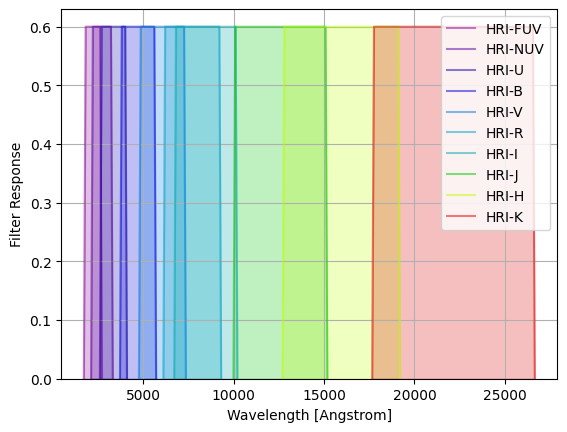

In [24]:
ecsvs = glob(output_dir + '/*.ecsv')
hri = load_filters(*ecsvs)

plot_filters(hri)